# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [2]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

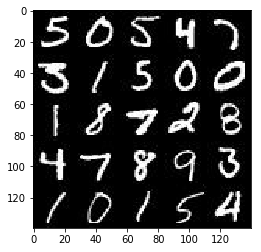

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

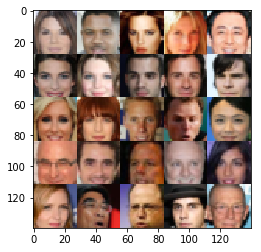

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # input images are 28x28x[1 or 3]
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        x1 = tf.maximum(x1*alpha, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(x2*alpha, x2)
        # 7x7x64
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding="valid")
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(x3*alpha, x3)
        # 7x7x256

#         print("Discrim final layer shape: {}".format(tf.shape(x3)))
        
        flatten = tf.reshape(x2, (-1, 7*7*128))
        
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        
        # First layer, fully connected
        fc = tf.layers.dense(z, 7*7*512, use_bias=False)
        fc = tf.reshape(fc, (-1, 7, 7, 512))
        fc = tf.maximum(alpha*fc, fc)
        
        # Second layer, conv transpose, 14x14x128
        x1 = tf.layers.conv2d_transpose(fc, 256, 5, strides=2, padding="same", use_bias=False)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        # Second layer, conv transpose, 14x14x128
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding="same", use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        # Output layer, conv transpose, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding="same", use_bias=False)
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    inputs_real, inputs_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
    steps = 0
    print_every = 10
    show_every = 100
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                
                # Run optimisers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, l_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, l_rate:learning_rate})
                
                # Print losses
                if steps % print_every == 0:
                    # At the end of every epoch, print the losses
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)
                         )
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                # Show mid-training images 
                if steps % show_every == 0:
                    show_generator_output(sess, 20, inputs_z, data_shape[3], data_image_mode)
                
        saver.save(sess, 'checkpoints/generator.ckpt')
        
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2... Discriminator Loss: 0.5829... Generator Loss: 2.6033
Epoch 0/2... Discriminator Loss: 0.7373... Generator Loss: 1.8804
Epoch 0/2... Discriminator Loss: 1.1141... Generator Loss: 3.7729
Epoch 0/2... Discriminator Loss: 1.4953... Generator Loss: 0.4458
Epoch 0/2... Discriminator Loss: 0.7904... Generator Loss: 3.0461
Epoch 0/2... Discriminator Loss: 0.1419... Generator Loss: 3.2738
Epoch 0/2... Discriminator Loss: 0.0941... Generator Loss: 3.5284
Epoch 0/2... Discriminator Loss: 0.5481... Generator Loss: 2.8039
Epoch 0/2... Discriminator Loss: 0.7254... Generator Loss: 5.5620
Epoch 0/2... Discriminator Loss: 4.2415... Generator Loss: 8.5861


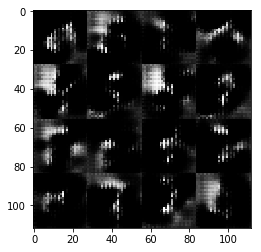

Epoch 0/2... Discriminator Loss: 0.4584... Generator Loss: 1.5668
Epoch 0/2... Discriminator Loss: 0.3643... Generator Loss: 3.8449
Epoch 0/2... Discriminator Loss: 0.2396... Generator Loss: 2.6703
Epoch 0/2... Discriminator Loss: 0.2509... Generator Loss: 2.6492
Epoch 0/2... Discriminator Loss: 0.2092... Generator Loss: 4.2878
Epoch 0/2... Discriminator Loss: 0.2032... Generator Loss: 3.4089
Epoch 0/2... Discriminator Loss: 0.3902... Generator Loss: 3.4919
Epoch 0/2... Discriminator Loss: 0.1699... Generator Loss: 4.0523
Epoch 0/2... Discriminator Loss: 10.0086... Generator Loss: 16.4163
Epoch 0/2... Discriminator Loss: 0.3119... Generator Loss: 2.0955


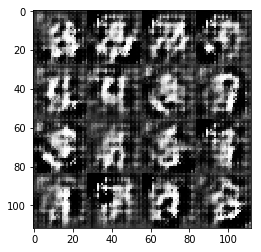

Epoch 0/2... Discriminator Loss: 0.4592... Generator Loss: 2.7793
Epoch 0/2... Discriminator Loss: 0.3565... Generator Loss: 3.1809
Epoch 0/2... Discriminator Loss: 0.3632... Generator Loss: 3.0991
Epoch 0/2... Discriminator Loss: 0.3056... Generator Loss: 3.4935
Epoch 0/2... Discriminator Loss: 0.1485... Generator Loss: 6.0968
Epoch 0/2... Discriminator Loss: 0.6664... Generator Loss: 4.5328
Epoch 0/2... Discriminator Loss: 3.6931... Generator Loss: 0.0701
Epoch 0/2... Discriminator Loss: 3.4462... Generator Loss: 0.0968
Epoch 0/2... Discriminator Loss: 0.1933... Generator Loss: 7.8182
Epoch 0/2... Discriminator Loss: 0.2953... Generator Loss: 4.4441


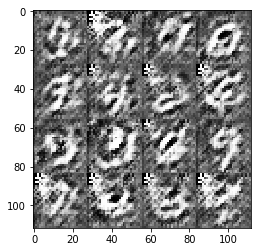

Epoch 0/2... Discriminator Loss: 0.2925... Generator Loss: 3.5604
Epoch 0/2... Discriminator Loss: 0.0889... Generator Loss: 4.3567
Epoch 0/2... Discriminator Loss: 0.1015... Generator Loss: 6.4024
Epoch 0/2... Discriminator Loss: 0.0506... Generator Loss: 7.5429
Epoch 0/2... Discriminator Loss: 0.1503... Generator Loss: 3.3436
Epoch 0/2... Discriminator Loss: 0.1188... Generator Loss: 4.0942
Epoch 0/2... Discriminator Loss: 0.3133... Generator Loss: 7.2180
Epoch 0/2... Discriminator Loss: 0.5066... Generator Loss: 2.7094
Epoch 0/2... Discriminator Loss: 1.3398... Generator Loss: 7.7456
Epoch 0/2... Discriminator Loss: 0.2876... Generator Loss: 4.2889


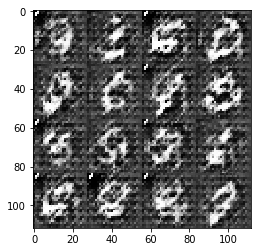

Epoch 0/2... Discriminator Loss: 0.3723... Generator Loss: 3.1278
Epoch 0/2... Discriminator Loss: 0.2276... Generator Loss: 3.6782
Epoch 0/2... Discriminator Loss: 0.2303... Generator Loss: 3.5552
Epoch 0/2... Discriminator Loss: 0.1019... Generator Loss: 4.3168
Epoch 0/2... Discriminator Loss: 0.0914... Generator Loss: 5.4041
Epoch 0/2... Discriminator Loss: 0.4087... Generator Loss: 4.7576
Epoch 1/2... Discriminator Loss: 1.4089... Generator Loss: 3.6394
Epoch 1/2... Discriminator Loss: 0.7257... Generator Loss: 1.2541
Epoch 1/2... Discriminator Loss: 0.3294... Generator Loss: 2.1329
Epoch 1/2... Discriminator Loss: 0.2698... Generator Loss: 3.0628


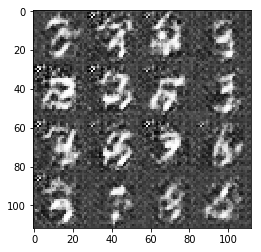

Epoch 1/2... Discriminator Loss: 1.1623... Generator Loss: 2.1588
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 4.1961
Epoch 1/2... Discriminator Loss: 0.4414... Generator Loss: 4.3747
Epoch 1/2... Discriminator Loss: 0.3141... Generator Loss: 2.7307
Epoch 1/2... Discriminator Loss: 3.0061... Generator Loss: 0.0772
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.6379
Epoch 1/2... Discriminator Loss: 0.5785... Generator Loss: 1.1448
Epoch 1/2... Discriminator Loss: 0.8170... Generator Loss: 0.9007
Epoch 1/2... Discriminator Loss: 0.4405... Generator Loss: 2.0225


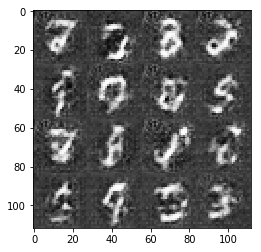

Epoch 1/2... Discriminator Loss: 0.3404... Generator Loss: 2.0589
Epoch 1/2... Discriminator Loss: 0.1955... Generator Loss: 2.8761
Epoch 1/2... Discriminator Loss: 0.2922... Generator Loss: 1.8844
Epoch 1/2... Discriminator Loss: 0.2363... Generator Loss: 2.1006
Epoch 1/2... Discriminator Loss: 0.1876... Generator Loss: 2.5584
Epoch 1/2... Discriminator Loss: 1.1647... Generator Loss: 2.0059
Epoch 1/2... Discriminator Loss: 1.8494... Generator Loss: 3.8450
Epoch 1/2... Discriminator Loss: 0.8251... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 0.3203... Generator Loss: 2.3648
Epoch 1/2... Discriminator Loss: 0.2957... Generator Loss: 2.1155


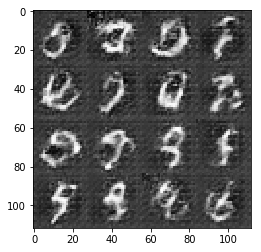

Epoch 1/2... Discriminator Loss: 0.2095... Generator Loss: 2.9179
Epoch 1/2... Discriminator Loss: 0.7313... Generator Loss: 0.8438
Epoch 1/2... Discriminator Loss: 1.2998... Generator Loss: 0.4277
Epoch 1/2... Discriminator Loss: 0.5926... Generator Loss: 2.9719
Epoch 1/2... Discriminator Loss: 0.8000... Generator Loss: 1.2813
Epoch 1/2... Discriminator Loss: 0.4128... Generator Loss: 2.8513
Epoch 1/2... Discriminator Loss: 0.4742... Generator Loss: 1.3756
Epoch 1/2... Discriminator Loss: 0.3712... Generator Loss: 1.6404
Epoch 1/2... Discriminator Loss: 0.2463... Generator Loss: 2.1602
Epoch 1/2... Discriminator Loss: 1.3603... Generator Loss: 0.3941


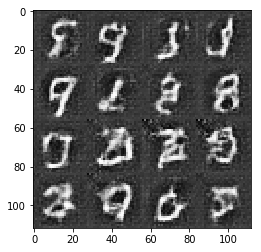

Epoch 1/2... Discriminator Loss: 1.0663... Generator Loss: 2.6394
Epoch 1/2... Discriminator Loss: 0.7945... Generator Loss: 2.3624
Epoch 1/2... Discriminator Loss: 1.7041... Generator Loss: 3.2278
Epoch 1/2... Discriminator Loss: 1.2609... Generator Loss: 3.9276
Epoch 1/2... Discriminator Loss: 0.5765... Generator Loss: 1.6353
Epoch 1/2... Discriminator Loss: 0.4819... Generator Loss: 1.8825
Epoch 1/2... Discriminator Loss: 0.2634... Generator Loss: 3.9790
Epoch 1/2... Discriminator Loss: 1.2677... Generator Loss: 2.8509
Epoch 1/2... Discriminator Loss: 0.7903... Generator Loss: 2.1147
Epoch 1/2... Discriminator Loss: 0.7799... Generator Loss: 2.7195


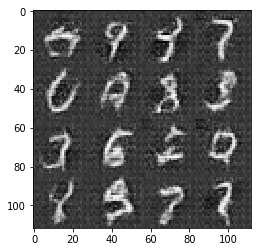

Epoch 1/2... Discriminator Loss: 0.5483... Generator Loss: 1.2622
Epoch 1/2... Discriminator Loss: 0.8230... Generator Loss: 0.7726
Epoch 1/2... Discriminator Loss: 0.5384... Generator Loss: 1.6422


In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1... Discriminator Loss: 0.5480... Generator Loss: 1.6816
Epoch 0/1... Discriminator Loss: 0.3128... Generator Loss: 2.9312
Epoch 0/1... Discriminator Loss: 0.5272... Generator Loss: 1.7577
Epoch 0/1... Discriminator Loss: 1.5800... Generator Loss: 9.5455
Epoch 0/1... Discriminator Loss: 0.0173... Generator Loss: 6.0921
Epoch 0/1... Discriminator Loss: 0.0274... Generator Loss: 4.4919
Epoch 0/1... Discriminator Loss: 0.0530... Generator Loss: 3.4852
Epoch 0/1... Discriminator Loss: 0.4251... Generator Loss: 1.4179
Epoch 0/1... Discriminator Loss: 0.6458... Generator Loss: 3.7373
Epoch 0/1... Discriminator Loss: 0.7424... Generator Loss: 3.4778


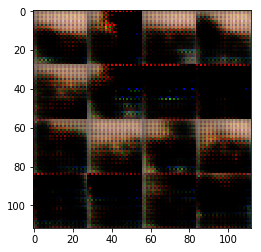

Epoch 0/1... Discriminator Loss: 0.7968... Generator Loss: 5.9339
Epoch 0/1... Discriminator Loss: 0.1894... Generator Loss: 2.8988
Epoch 0/1... Discriminator Loss: 3.0931... Generator Loss: 0.7563
Epoch 0/1... Discriminator Loss: 0.6457... Generator Loss: 1.3016
Epoch 0/1... Discriminator Loss: 1.1121... Generator Loss: 2.2764
Epoch 0/1... Discriminator Loss: 0.1804... Generator Loss: 3.8974
Epoch 0/1... Discriminator Loss: 0.6298... Generator Loss: 2.0848
Epoch 0/1... Discriminator Loss: 0.2323... Generator Loss: 3.8822
Epoch 0/1... Discriminator Loss: 0.5821... Generator Loss: 1.3382
Epoch 0/1... Discriminator Loss: 0.3976... Generator Loss: 2.7901


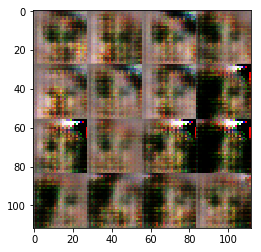

Epoch 0/1... Discriminator Loss: 0.1330... Generator Loss: 2.9936
Epoch 0/1... Discriminator Loss: 1.6384... Generator Loss: 5.5377
Epoch 0/1... Discriminator Loss: 0.1371... Generator Loss: 4.8142
Epoch 0/1... Discriminator Loss: 0.9450... Generator Loss: 2.9869
Epoch 0/1... Discriminator Loss: 0.2908... Generator Loss: 4.6616
Epoch 0/1... Discriminator Loss: 0.3429... Generator Loss: 3.7248
Epoch 0/1... Discriminator Loss: 0.0661... Generator Loss: 5.6440
Epoch 0/1... Discriminator Loss: 2.3904... Generator Loss: 8.6144
Epoch 0/1... Discriminator Loss: 0.5028... Generator Loss: 2.9346
Epoch 0/1... Discriminator Loss: 1.8943... Generator Loss: 0.2303


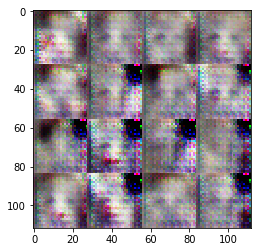

Epoch 0/1... Discriminator Loss: 0.1614... Generator Loss: 2.8572
Epoch 0/1... Discriminator Loss: 0.2551... Generator Loss: 3.5079
Epoch 0/1... Discriminator Loss: 0.0695... Generator Loss: 5.4305
Epoch 0/1... Discriminator Loss: 4.3001... Generator Loss: 0.0531
Epoch 0/1... Discriminator Loss: 0.1818... Generator Loss: 5.1254
Epoch 0/1... Discriminator Loss: 0.0371... Generator Loss: 7.2467
Epoch 0/1... Discriminator Loss: 0.1237... Generator Loss: 3.9456
Epoch 0/1... Discriminator Loss: 0.1580... Generator Loss: 3.1724
Epoch 0/1... Discriminator Loss: 0.1553... Generator Loss: 3.5169
Epoch 0/1... Discriminator Loss: 0.0495... Generator Loss: 4.8588


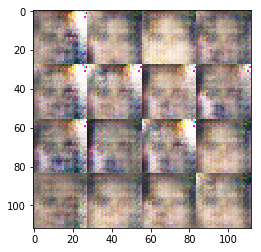

Epoch 0/1... Discriminator Loss: 0.0599... Generator Loss: 5.1964
Epoch 0/1... Discriminator Loss: 0.0868... Generator Loss: 4.3787
Epoch 0/1... Discriminator Loss: 0.5718... Generator Loss: 4.7477
Epoch 0/1... Discriminator Loss: 0.5716... Generator Loss: 2.4927
Epoch 0/1... Discriminator Loss: 1.4279... Generator Loss: 1.4700
Epoch 0/1... Discriminator Loss: 0.4651... Generator Loss: 8.5783
Epoch 0/1... Discriminator Loss: 0.9650... Generator Loss: 3.5578
Epoch 0/1... Discriminator Loss: 0.9897... Generator Loss: 5.1870
Epoch 0/1... Discriminator Loss: 0.2985... Generator Loss: 3.2864
Epoch 0/1... Discriminator Loss: 2.4836... Generator Loss: 8.2392


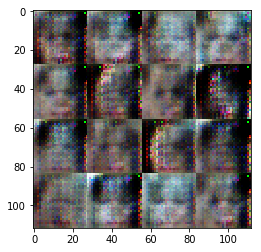

Epoch 0/1... Discriminator Loss: 0.6244... Generator Loss: 9.9983
Epoch 0/1... Discriminator Loss: 0.4867... Generator Loss: 1.8063
Epoch 0/1... Discriminator Loss: 1.2582... Generator Loss: 4.3490
Epoch 0/1... Discriminator Loss: 0.4649... Generator Loss: 3.5310
Epoch 0/1... Discriminator Loss: 0.9556... Generator Loss: 6.4458
Epoch 0/1... Discriminator Loss: 0.3991... Generator Loss: 2.6417
Epoch 0/1... Discriminator Loss: 0.6286... Generator Loss: 1.6488
Epoch 0/1... Discriminator Loss: 0.1861... Generator Loss: 4.7788
Epoch 0/1... Discriminator Loss: 2.2246... Generator Loss: 0.2724
Epoch 0/1... Discriminator Loss: 1.8590... Generator Loss: 0.3744


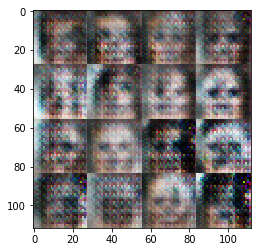

Epoch 0/1... Discriminator Loss: 2.8470... Generator Loss: 1.8629
Epoch 0/1... Discriminator Loss: 1.6560... Generator Loss: 2.8240
Epoch 0/1... Discriminator Loss: 1.3106... Generator Loss: 0.8781
Epoch 0/1... Discriminator Loss: 1.5193... Generator Loss: 1.2526
Epoch 0/1... Discriminator Loss: 1.2923... Generator Loss: 1.5112
Epoch 0/1... Discriminator Loss: 2.0250... Generator Loss: 0.7304
Epoch 0/1... Discriminator Loss: 1.7103... Generator Loss: 1.0276
Epoch 0/1... Discriminator Loss: 1.3340... Generator Loss: 1.0042
Epoch 0/1... Discriminator Loss: 1.1170... Generator Loss: 2.1293
Epoch 0/1... Discriminator Loss: 2.9650... Generator Loss: 3.4807


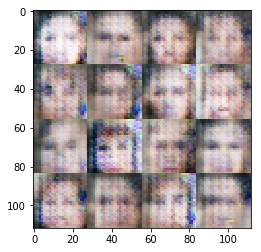

Epoch 0/1... Discriminator Loss: 1.9341... Generator Loss: 1.0440
Epoch 0/1... Discriminator Loss: 1.1577... Generator Loss: 0.7487
Epoch 0/1... Discriminator Loss: 1.4313... Generator Loss: 1.0654
Epoch 0/1... Discriminator Loss: 0.4246... Generator Loss: 2.8819
Epoch 0/1... Discriminator Loss: 0.9158... Generator Loss: 0.9913
Epoch 0/1... Discriminator Loss: 1.1601... Generator Loss: 0.6146
Epoch 0/1... Discriminator Loss: 1.0791... Generator Loss: 1.7898
Epoch 0/1... Discriminator Loss: 2.8604... Generator Loss: 2.1091
Epoch 0/1... Discriminator Loss: 1.3869... Generator Loss: 0.5374
Epoch 0/1... Discriminator Loss: 0.4472... Generator Loss: 1.6011


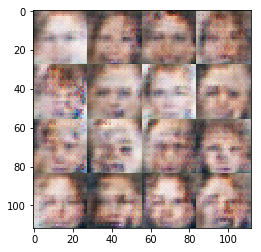

Epoch 0/1... Discriminator Loss: 1.1784... Generator Loss: 1.2369
Epoch 0/1... Discriminator Loss: 0.9292... Generator Loss: 0.7567
Epoch 0/1... Discriminator Loss: 1.3335... Generator Loss: 0.5560
Epoch 0/1... Discriminator Loss: 1.4750... Generator Loss: 0.3736
Epoch 0/1... Discriminator Loss: 1.0346... Generator Loss: 6.6679
Epoch 0/1... Discriminator Loss: 1.2843... Generator Loss: 0.5343
Epoch 0/1... Discriminator Loss: 1.5138... Generator Loss: 0.6920
Epoch 0/1... Discriminator Loss: 1.2178... Generator Loss: 0.4894
Epoch 0/1... Discriminator Loss: 2.2125... Generator Loss: 1.9173
Epoch 0/1... Discriminator Loss: 1.1020... Generator Loss: 0.7951


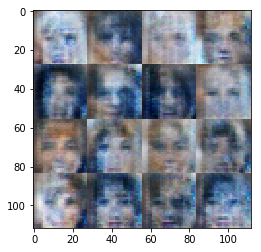

Epoch 0/1... Discriminator Loss: 1.1826... Generator Loss: 0.8759
Epoch 0/1... Discriminator Loss: 0.8610... Generator Loss: 1.3011
Epoch 0/1... Discriminator Loss: 1.1071... Generator Loss: 1.4539
Epoch 0/1... Discriminator Loss: 0.9249... Generator Loss: 0.8099
Epoch 0/1... Discriminator Loss: 0.9907... Generator Loss: 1.0546
Epoch 0/1... Discriminator Loss: 0.6138... Generator Loss: 1.3450
Epoch 0/1... Discriminator Loss: 1.4230... Generator Loss: 0.4340
Epoch 0/1... Discriminator Loss: 0.8992... Generator Loss: 0.7767
Epoch 0/1... Discriminator Loss: 1.4030... Generator Loss: 1.8320
Epoch 0/1... Discriminator Loss: 1.1931... Generator Loss: 1.7022


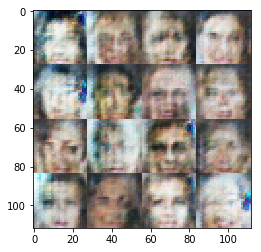

Epoch 0/1... Discriminator Loss: 1.2898... Generator Loss: 1.1508
Epoch 0/1... Discriminator Loss: 1.8447... Generator Loss: 0.2741
Epoch 0/1... Discriminator Loss: 1.8387... Generator Loss: 0.5725
Epoch 0/1... Discriminator Loss: 0.6685... Generator Loss: 1.9797
Epoch 0/1... Discriminator Loss: 0.7350... Generator Loss: 1.3458
Epoch 0/1... Discriminator Loss: 1.2474... Generator Loss: 0.8925
Epoch 0/1... Discriminator Loss: 1.1152... Generator Loss: 2.3455
Epoch 0/1... Discriminator Loss: 0.6226... Generator Loss: 1.0778
Epoch 0/1... Discriminator Loss: 1.3593... Generator Loss: 0.4660
Epoch 0/1... Discriminator Loss: 0.5869... Generator Loss: 1.1717


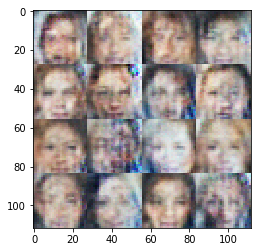

Epoch 0/1... Discriminator Loss: 1.0298... Generator Loss: 1.0171
Epoch 0/1... Discriminator Loss: 1.1135... Generator Loss: 0.6805
Epoch 0/1... Discriminator Loss: 1.0290... Generator Loss: 1.8346
Epoch 0/1... Discriminator Loss: 2.7711... Generator Loss: 3.4294
Epoch 0/1... Discriminator Loss: 0.6679... Generator Loss: 1.0827
Epoch 0/1... Discriminator Loss: 1.1753... Generator Loss: 1.0170
Epoch 0/1... Discriminator Loss: 1.8598... Generator Loss: 2.7955
Epoch 0/1... Discriminator Loss: 0.8501... Generator Loss: 0.9619
Epoch 0/1... Discriminator Loss: 0.8481... Generator Loss: 1.7650
Epoch 0/1... Discriminator Loss: 0.7984... Generator Loss: 1.9423


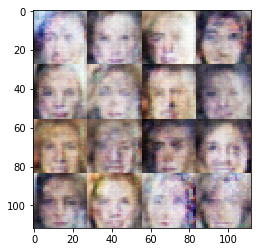

Epoch 0/1... Discriminator Loss: 0.8425... Generator Loss: 0.7844
Epoch 0/1... Discriminator Loss: 1.0213... Generator Loss: 0.9734
Epoch 0/1... Discriminator Loss: 1.6515... Generator Loss: 1.3398
Epoch 0/1... Discriminator Loss: 1.1115... Generator Loss: 2.4421
Epoch 0/1... Discriminator Loss: 0.4064... Generator Loss: 2.4955
Epoch 0/1... Discriminator Loss: 2.1763... Generator Loss: 0.1957
Epoch 0/1... Discriminator Loss: 0.8590... Generator Loss: 1.2141
Epoch 0/1... Discriminator Loss: 1.2617... Generator Loss: 2.9620
Epoch 0/1... Discriminator Loss: 1.6513... Generator Loss: 0.3140
Epoch 0/1... Discriminator Loss: 1.0730... Generator Loss: 0.5724


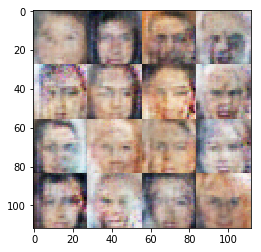

Epoch 0/1... Discriminator Loss: 0.6710... Generator Loss: 1.1785
Epoch 0/1... Discriminator Loss: 3.2610... Generator Loss: 4.2087
Epoch 0/1... Discriminator Loss: 1.1008... Generator Loss: 1.1132
Epoch 0/1... Discriminator Loss: 1.4461... Generator Loss: 0.4105
Epoch 0/1... Discriminator Loss: 2.1314... Generator Loss: 0.9598
Epoch 0/1... Discriminator Loss: 2.1473... Generator Loss: 2.7665
Epoch 0/1... Discriminator Loss: 0.8393... Generator Loss: 0.8009
Epoch 0/1... Discriminator Loss: 0.7746... Generator Loss: 1.5527
Epoch 0/1... Discriminator Loss: 0.9575... Generator Loss: 0.8084
Epoch 0/1... Discriminator Loss: 0.4794... Generator Loss: 1.4118


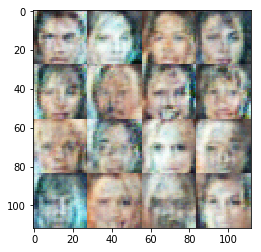

Epoch 0/1... Discriminator Loss: 1.0342... Generator Loss: 0.7090
Epoch 0/1... Discriminator Loss: 1.0072... Generator Loss: 0.6397
Epoch 0/1... Discriminator Loss: 1.3865... Generator Loss: 1.0320
Epoch 0/1... Discriminator Loss: 1.1165... Generator Loss: 0.6431
Epoch 0/1... Discriminator Loss: 0.3954... Generator Loss: 1.7681
Epoch 0/1... Discriminator Loss: 3.4270... Generator Loss: 0.0483
Epoch 0/1... Discriminator Loss: 0.7660... Generator Loss: 1.4036
Epoch 0/1... Discriminator Loss: 2.4639... Generator Loss: 3.3864
Epoch 0/1... Discriminator Loss: 2.2875... Generator Loss: 1.5231
Epoch 0/1... Discriminator Loss: 2.0190... Generator Loss: 0.2730


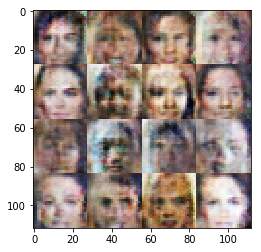

Epoch 0/1... Discriminator Loss: 0.9048... Generator Loss: 1.0415
Epoch 0/1... Discriminator Loss: 0.9338... Generator Loss: 0.7394
Epoch 0/1... Discriminator Loss: 0.9359... Generator Loss: 1.2695
Epoch 0/1... Discriminator Loss: 0.6918... Generator Loss: 0.8662
Epoch 0/1... Discriminator Loss: 1.3564... Generator Loss: 2.8519
Epoch 0/1... Discriminator Loss: 2.3014... Generator Loss: 2.2458
Epoch 0/1... Discriminator Loss: 1.6953... Generator Loss: 0.4119
Epoch 0/1... Discriminator Loss: 0.8113... Generator Loss: 2.9101


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.